## Common Class

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import math

from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from ta.momentum import RSIIndicator

In [414]:
class Common_Class():

    def __init__(self, symbol, start, end, interval, capital, transcation_cost, benchmark,verbose = True):        
        #new dicts as now there will be multiple stocks. Each stock will have its own position/quantity etc
        self.symbol = symbol
        self.all_data = {stock:pd.DataFrame() for stock in self.symbol}
        self.position = {stock:0 for stock in self.symbol}
        self.quantity = {stock:0 for stock in self.symbol}
        for stock in symbol:
            self.quantity['{}'.format(stock)] = 0 #can also do at run strategy, but its different design
        self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details
        self.start = start
        self.end = end
        self.interval = interval
        self.initial_capital = capital # this is the initial capital you want to trade with
        self.capital = capital # this capital will change depending on trades
        self.transaction_cost = transcation_cost # the transaction cost for trading
        self.trades = 0 # Number of trades
        self.verbose = verbose # if you want to see detailed output (logs)
        self.benchmark = benchmark
        self.prepare_data() # prepares the data
        
    def prepare_data(self):
        # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
        # we will calculate the returns though.
        # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.
        # Get the data for all the tickers
        for ticker in self.symbol:
            hist_stock = pdr.get_data_yahoo(ticker, start = self.start, end = self.end,)
            bt_data = pd.DataFrame()
            bt_data["Close_Price"] = hist_stock["Adj Close"]
            bt_data["Open_Price"] = hist_stock["Open"]
            bt_data["Low_Price"] = hist_stock["Low"]
            bt_data["High_Price"] = hist_stock["High"]
            bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
            bt_data = bt_data.dropna()
            self.all_data[ticker] = bt_data

        # Get the data for the benchmark
        hist_benchmark = pdr.get_data_yahoo(self.benchmark, start = self.start, end = self.end,)
        bt_data = pd.DataFrame()
        bt_data["Close_Price"] = hist_benchmark["Adj Close"]
        bt_data["Benchmark Returns"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
        bt_data = bt_data.dropna()
        self.benchmark_df = bt_data
    
    def close_graph(self, ticker):
        plt.figure(figsize=(15, 5))
        plt.plot(self.all_data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Close Prices of {}".format(ticker))
        plt.legend()
        plt.grid()
        plt.show()

    def return_date_price(self, bar, stock, price_type = 'Close'): #now we will also pass the stock as parameter
        # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
        # Since we have modeled close prices, we will get the price and date
        i = str(stock)
        date = str(self.all_data[i].index[bar])[:10]  # :10 to only get the date
        if (price_type == "Close"): price = self.all_data[i].Close_Price.iloc[bar]
        elif (price_type == "Open"): price = self.all_data[i].Open_Price.iloc[bar]
        return date, price

    def realised_balance(self, bar):
        #returns the realised capital in your account at a given time period / bar
        date, price = self.return_date_price(bar, self.symbol[0]) # only concerned with date so any stock will do
        print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

    def unrealised_balance(self, bar):
        #returns you the unrealised capital (trades in progress) in your account at a given time period / bar
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub =  ub + self.quantity['{}'.format(stock)] *price
        #print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

    def total_balance(self, bar):
        #Unrealised plus realised
        ub = 0
        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock)
            ub =  ub + self.quantity['{}'.format(stock)] *price
        tb = ub + self.capital
        #print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
        return tb

    def store_results(self, trade, date, position, price, symbol, quantity, capital):
        trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
        self.stored_data = pd.concat([self.stored_data, trade_detail])

    def performance_plots(self):# once we have dataframe of daily account balances
        Final_result_data = self.Final_result_data #saving time to write self everywhere
        interval = str(self.interval)
        f,ax = plt.subplots(2,3,figsize=(20,10))

        #plot 1: Close Price os stock
        plt.subplot(2, 3, 1)
        for stock in self.symbol:
            plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
        plt.title("Cum Log returns of included stocks")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 2: Histogram of dtrstegy returns
        plt.subplot(2, 3, 2)
        plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
        plt.title("Histogram of Strategy returns")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 3: Strategy vs Instrument
        plt.subplot(2, 3, 3)
        plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
        plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
        plt.title("Strategy Vs Stock Cum Return Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 4: Drawdown
        plt.subplot(2, 3, 4)
        plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
        plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
        plt.title("Drawdown")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        #plot 5: Equity Curve
        plt.subplot(2, 3,  5)
        plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
        plt.title("Equity Curve")
        plt.xlabel(interval)
        plt.legend()
        plt.grid()

        plt.suptitle("Performance Plots")
        f.delaxes(ax[1,2]) # to delete the last subplot

        plt.show()

    def performance(self):
        # stored data has  [trade, date, position, price, symbol, quantity, capital]
        #B = self.stored_data # this will have many rows ; n(number of instruments) times more
        #C = self.all_data # will need this to aggregate the returns from all stocks
        #B.index = range(B.shape[0]/len(self.symbol))

        #Since the stocks are not stored in arranged manner, we need to arrange them so that we can get the entry price and exit price for each day
        #stored data has many rows, we will aggregate day wise

        df = pd.DataFrame() # creating a new datframe to store aggregated values

        df['capital'] = self.total_balance_df
        #df.index = range(self.stored_data.shape[0]/len(self.symbol)) # shape[0] to get the length of rows of each stock and make an index for dataframe df

        trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time, for daily, its fine
        trade_end_date = df['capital'].index[-1] # This will work when interval is 1D

        #Also, since we have multiple stocks, we need to calculate expected returns to comapre against the strategy

        for stock in self.symbol:
            df['Returns_{}'.format(stock)] = self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()
        c= df.columns #fetch all the columns of datframe
        df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divvide by number of stocks. Equal weightage
        df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
        df.index = range(df.shape[0])

        df['capital_after_settlement'] = df['capital'].shift(-1)

        # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
        #Remember, you can change the returns on investment based on the capital you trade

        df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
        df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
        df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

        # for drawdown calculation
        df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
        df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]
        # The maximum difference is refered as "Drawdown"

        #storing the results in Final_result data
        Final_result_data = df

        Drawdown = Final_result_data["drawdown"].max()*100

        zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
        delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])


        self.Final_result_data = Final_result_data

        # Add benchmark returns
        self.benchmark_df.index = pd.to_datetime(self.benchmark_df.index.date)
        self.benchmark_df= self.benchmark_df[trade_start_date:trade_end_date]
        self.Final_result_data['Benchmark Returns'] = list(self.benchmark_df['Benchmark Returns'])
        benchmark_annual_regular_returns = np.exp(self.Final_result_data['Benchmark Returns'].mean() * 252) -1

        # Beta
        matrix = self.Final_result_data[['capital_log_returns', 'Benchmark Returns']].cov()
        beta = matrix.iat[0, 1] / matrix.iat[1, 1]

        # Portfolio information ratio
        portfolio_log_returns = self.Final_result_data['capital_log_returns'].sum() * 100
        portfolio_normal_returns = (self.capital - self.initial_capital) / self.initial_capital * 100
        portfolio_annual_mean_returns = np.exp(self.Final_result_data['capital_log_returns'].mean() * 252) - 1
        portfolio_annual_regular_std = (np.exp(self.Final_result_data['capital_log_returns']) -1).std() * (252 ** 0.5)
        portfolio_annual_sharpe_ratio = portfolio_annual_mean_returns / portfolio_annual_regular_std
        
        self.Final_result_data['portfolio-benchmark'] = self.Final_result_data['capital_log_returns'] - self.Final_result_data['Benchmark Returns']
        average_of_difference = self.Final_result_data['portfolio-benchmark'].mean()
        std_of_difference = self.Final_result_data['portfolio-benchmark'].std()
        daily_ir = average_of_difference / std_of_difference
        annual_ir = daily_ir * (252 ** 0.5)

        # Treynor ratio
        portfolio_treynor_ratio = portfolio_annual_mean_returns / beta

        # Max drawdown
        self.Final_result_data['portfolio_gross_cum_returns'] = self.Final_result_data['capital_log_returns'].cumsum().apply(np.exp)
        self.Final_result_data['portfolio_gross_cum_max_returns'] = self.Final_result_data['portfolio_gross_cum_returns'].cummax()
        max_drawdown = (self.Final_result_data['portfolio_gross_cum_max_returns'] - self.Final_result_data['portfolio_gross_cum_returns']).max()

        # Calmar ratio
        portfolio_calmar_ratio = portfolio_annual_mean_returns / max_drawdown

        # Sortino ratio
        portfolio_negative_returns_df = self.Final_result_data[self.Final_result_data['capital_log_returns'] < 0]
        annual_negative_portfolio_std = (np.exp(portfolio_negative_returns_df['capital_log_returns']) - 1).std() * (252 ** 0.5)
        portfolio_sortino_ratio = portfolio_annual_mean_returns / annual_negative_portfolio_std

        print("=" *50)
        print("Starting capital: {}".format(self.initial_capital))
        print("Final capital: {:0.2f}".format(self.capital))
        print('Log Portfolio returns: {:0.2f} %'.format(portfolio_log_returns))
        print("Normal Portfolio returns: {:0.2f} %".format(portfolio_normal_returns))
        print('Portfolio Annual Mean returns: {:0.2f}'.format(portfolio_annual_mean_returns))
        print('Portfolio Annual Regular std: {:0.2f}'.format(portfolio_annual_regular_std))
        print('Portfolio Annual Sharpe Ratio: {:0.2f}'.format(portfolio_annual_sharpe_ratio))
        print('{} Benchmark Annual Mean returns: {:0.2f}'.format(self.benchmark, benchmark_annual_regular_returns))
        print('Annual Information Ratio: {:0.2f}'.format(annual_ir))
        print('Portfolio Treynor Ratio: {:0.2f}'.format(portfolio_treynor_ratio))
        print('Portfolio Calmar Ratio: {:0.2f}'.format(portfolio_calmar_ratio))
        print('Portfolio Sortino Ratio: {:0.2f}'.format(portfolio_sortino_ratio))
        print("The maximum drawdown: {:.2f} %".format(Drawdown))
        print("The maximum drawdown period: {:.2f} days".format(delta_values.max()))
        print("The total trades taken by the strategy: {}".format(self.trades))
        # print("\nDistribution of exits in percentages\n",self.bt_data[self.bt_data.Close_Entry != ""].Close_Entry.value_counts(normalize=True))
        print("=" *50)


    def buy_order(self,bar,stock,quantity=None, dollar =None ):
        date, price = self.return_date_price(bar,stock,price_type="Close")
        if quantity == None:
            quantity =  math.floor(dollar/(price* (self.transaction_cost+1)))
        self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
        self.trades = self.trades + 1
        self.position['{}'.format(stock)] = 1
        tb = self.total_balance(bar)
        #self.quantity['{}'.format(stock)]*price + self.capital # this is just for one stock, however, I need for all the stocks
        self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


        if self.verbose:
            print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)
            #self.unrealised_balance(bar)
            #self.total_balance(bar)


    def sell_order(self,bar,stock, quantity=None, dollar=None ):
        date, price = self.return_date_price(bar, stock,price_type="Close")
        if quantity == None:
            quantity = math.floor(dollar/(price* (self.transaction_cost+1)))
        self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
        self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
        self.trades = self.trades + 1
        self.position['{}'.format(stock)] = -1
        tb = self.total_balance(bar) # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD
        self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


        if self.verbose:
            print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
            print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
            self.realised_balance(bar)
            #self.unrealised_balance(bar)
            #self.total_balance(bar)

    def last_trade(self, bar):# thi sneeds to be check for all open positions of all stocks

        for stock in self.symbol:
            date, price = self.return_date_price(bar, stock,price_type="Close")
            last_quantity = self.quantity['{}'.format(stock)]
            self.capital = self.capital + last_quantity * price
            self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
            self.trades = self.trades +1
            if self.position['{}'.format(stock)] == -1: # if closing out a short position
                last_quantity = - last_quantity # to keep a positve nymber in records. Note, self.quantity is always maintianing a +/- sign.
                self.position['{}'.format(stock)] = 1 # to record we are buying to close out
            else:
                last_quantity =  last_quantity # to keep a positve nymber in records
                self.position['{}'.format(stock)] = -1 # to record we are selling to close out
            #self.position = 0
            tb = self.total_balance(bar)
            self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

            if self.verbose:
                print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))

## Trading Strategy Logic

In [574]:
class MA_Strategy(Common_Class):
    
    def __init__(self,symbol, benchmark,start, end, interval, capital, transcation_cost, primary_trend_window,buy_on,long_sl_ATR_multiple,risk_reward_long,
                 close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,
                 close_n_sma_distance_short_multiple,short_rsi_limit,verbose):
        super().__init__(symbol, start, end, interval, capital, transcation_cost,benchmark,verbose)
        self.primary_trend_window = primary_trend_window
        self.buy_on= buy_on
        self.long_sl_ATR_multiple = long_sl_ATR_multiple,
        self.risk_reward_long = risk_reward_long,
        self.close_n_sma_distance_long_multiple= close_n_sma_distance_long_multiple,
        self.long_rsi_limit = long_rsi_limit,
        self.short_sl_ATR_multiple = short_sl_ATR_multiple,
        self.risk_reward_short = risk_reward_short,
        self.close_n_sma_distance_short_multiple = close_n_sma_distance_short_multiple,
        self.short_rsi_limit = short_rsi_limit
        self.Final_result_data = pd.DataFrame()

    def close_position(self, ticker, bar):
        if self.position[ticker] == 1:
            self.sell_order(bar,ticker, quantity = self.quantity[ticker]) # to clear previous long position
            
        elif self.position[ticker] == -1:
            self.buy_order(bar,ticker, quantity = -self.quantity[ticker]) #to clear previous short position and therefore negative quantity.
            
        self.position[ticker] = 0
    
    def go_long(self, ticker, bar, quantity = None, dollar = None):
        if quantity:
            self.buy_order (bar,ticker, quantity = quantity) # to create new fresh order
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
                self.buy_order(bar,ticker, dollar = dollar)
        
    def go_short(self, ticker, bar, quantity = None, dollar = None):
        if quantity:
            self.sell_order(bar,ticker, quantity = quantity) # to create new fresh order
        elif dollar:
            if dollar == 'all':
                dollar = self.capital
                self.sell_order(bar,ticker, dollar = dollar)


    def visualise_strategy(self, ticker,  axs):
            axs.plot(self.all_data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
            axs.plot(self.all_data[ticker]["SMA"], color='b', label='Short term MA')
            # axs.plot(self.all_data[ticker]["LTMA"], color='r', label='Long term MA')
            
            # Entry Points
            open_long = self.all_data[ticker]['Open_Entry'] == "Open Long"
            open_short = self.all_data[ticker]['Open_Entry'] == "Open Short"
            
            # Exit points
            close_short_tp = (self.all_data[ticker]['Close_Entry'] == "Close Short at TP")
            close_long_tp = (self.all_data[ticker]['Close_Entry'] == "Close Long at TP")
            close_short_sl = (self.all_data[ticker]['Close_Entry'] == "Close Short at SL")
            close_long_sl = (self.all_data[ticker]['Close_Entry'] == "Close Long at SL")
            
            axs.plot(self.all_data[ticker][open_long].index, self.all_data[ticker][open_long]['Close_Price'], '^',
                 color = 'g', markersize = 12,alpha=0.6, label="Open Long")

            axs.plot(self.all_data[ticker][open_short].index, self.all_data[ticker][open_short]['Close_Price'], 'v',
                     color = 'r', markersize = 12,alpha=0.6, label="Open Short")

            axs.plot(self.all_data[ticker][close_long_tp].index, self.all_data[ticker][close_long_tp]['Close_Price'], '*',
                     color = 'g', markersize = 12,alpha=0.8, label="TP Long")

            axs.plot(self.all_data[ticker][close_short_tp].index, self.all_data[ticker][close_short_tp]['Close_Price'], '*',
                     color = 'r', markersize = 12,alpha=0.8, label="TP Short")

            axs.plot(self.all_data[ticker][close_long_sl].index, self.all_data[ticker][close_long_sl]['Close_Price'], 'x',
                     color = 'g', markersize = 12,alpha=0.8, label="SL Long", mew=4)

            axs.plot(self.all_data[ticker][close_short_sl].index, self.all_data[ticker][close_short_sl]['Close_Price'], 'x',
                     color = 'r', markersize = 12,alpha=0.8, label="SL Short", mew=4)

            axs.set_xlabel("Days")
            axs.set_ylabel("Price")
            axs.set_title("Price of {}".format(ticker))
            axs.legend()
            plt.grid()

    def visualise_position(self, ticker, axs):
            axs.plot(self.all_data[ticker]["Final Position"])
            axs.set_title("Long/Short status for {}".format(ticker))
            axs.grid()

    def visualise_stock_returns_distribution(self, ticker, axs):
            axs.hist(self.all_data[ticker][self.all_data[ticker]["Strategy_Returns"] != 0]["Strategy_Returns"], bins = 40, label='Strategy Returns', alpha=0.5)
            axs.hist(self.all_data[ticker][self.all_data[ticker]["Stock_Returns"] != 0]["Stock_Returns"], bins = 40, label='Stock Returns', alpha=0.5)
            axs.set_title("Histogram of Stock Daily Log Returns for {}".format(ticker))
            axs.legend()
            axs.grid()

    def visualise_stock_and_strategy_returns(self, ticker, axs):
            axs.plot(self.all_data[ticker][["Strategy_Returns"]].cumsum(), label='Strategy_Returns')
            axs.plot(self.all_data[ticker][["Stock_Returns"]].cumsum(), label='Stock_Returns')
            axs.legend()
            axs.set_title('Stock vs Strategy Returns for {}'.format(ticker))
            axs.grid()

    def add_technicals(self, ticker):
        SMA = SMAIndicator(close = self.all_data[ticker]["Close_Price"], window = self.primary_trend_window, fillna= False)
        self.all_data[ticker]["SMA"] = SMA.sma_indicator()
        
        ATR = AverageTrueRange(high = self.all_data[ticker]["High_Price"],
                           low = self.all_data[ticker]["Low_Price"],
                           close = self.all_data[ticker]["Close_Price"])
        self.all_data[ticker]['ATR'] = ATR.average_true_range()
        ATR_SMA = SMAIndicator(close = self.all_data[ticker]['ATR'], window = 14, fillna= False)
        self.all_data[ticker]["ATR_SMA"] = ATR_SMA.sma_indicator()
        
        MACD_ = MACD(close = self.all_data[ticker]["Close_Price"]) 
        self.all_data[ticker]['MACD Fast'] = MACD_.macd()
        self.all_data[ticker]['MACD Slow'] = MACD_.macd_signal()
        
        RSI = RSIIndicator(close =  self.all_data[ticker]["Close_Price"])
        self.all_data[ticker]['RSI'] = RSI.rsi()

        self.all_data[ticker]['Stop Loss Long'] = self.all_data[ticker]["Open_Price"] - self.long_sl_ATR_multiple*self.all_data[ticker]['ATR'] # 2
        self.all_data[ticker]['Take Profit Long'] = self.all_data[ticker]["Open_Price"] +self.risk_reward_long*(self.long_sl_ATR_multiple*self.all_data[ticker]['ATR']) # 1

        self.all_data[ticker]['Stop Loss Short'] = self.all_data[ticker]["Open_Price"] + self.short_sl_ATR_multiple*self.all_data[ticker]['ATR'] # 1
        self.all_data[ticker]['Take Profit Short'] = self.all_data[ticker]["Open_Price"]-self.risk_reward_short*(self.short_sl_ATR_multiple*self.all_data[ticker]['ATR']) # 0.5


        ## Signal Logic
        self.all_data[ticker]['signal_1'] = np.where( 
                            (self.all_data[ticker]['Close_Price'] > (self.all_data[ticker]['SMA'] - self.close_n_sma_distance_short_multiple*self.all_data[ticker]['ATR_SMA']) ) & (self.all_data[ticker]['Close_Price'] < self.all_data[ticker]['SMA']),
                            -1.0,   0) # When it is between the close and abit below it, we short, 0,5

        self.all_data[ticker]['signal_1'] = np.where( 
                            (self.all_data[ticker]['Close_Price'] < (self.all_data[ticker]['SMA'] + self.close_n_sma_distance_long_multiple*self.all_data[ticker]['ATR_SMA']) ) & (self.all_data[ticker]['Close_Price'] > self.all_data[ticker]['SMA']) ,
                            1.0,  self.all_data[ticker]['signal_1']) # When it is between the close and abit above it, we long, 2

        self.all_data[ticker]['signal_2'] = np.where(self.all_data[ticker]['MACD Fast'] >  self.all_data[ticker]['MACD Slow'],1.0,-1.0)
        self.all_data[ticker]['signal_3'] = np.where(self.all_data[ticker]['ATR_SMA'] >  self.all_data[ticker]['ATR'],1.0,-1.0)
        
        self.all_data[ticker]['Signal Combined'] = ( self.all_data[ticker]['signal_1']+ self.all_data[ticker]['signal_2'] + self.all_data[ticker]['signal_3'] )/3.0
        self.all_data[ticker]['Signal Clean'] = self.all_data[ticker]['Signal Combined'].map(lambda x : 0 if x not in [-1.0,1.0] else x)
        self.all_data[ticker]['Strength of Signal'] = ((abs(self.all_data[ticker]['Close_Price'] - self.all_data[ticker]['SMA'])/self.all_data[ticker]['Close_Price'] + abs(self.all_data[ticker]['MACD Fast'] -  self.all_data[ticker]['MACD Slow']))) * self.all_data[ticker]['Signal Clean']
        self.strengths_df[ticker] = self.all_data[ticker]['Strength of Signal']
        self.all_data[ticker]['Final Position'] = 0
        self.all_data[ticker][ "Open_Entry"] = ""
        self.all_data[ticker][ "Close_Entry"] = ""
    
    def run_strategy(self):
            self.strengths_df = pd.DataFrame(columns=self.symbol)
            
            for ticker in self.all_data.keys():
                # Get indicators for all the tickers
                self.add_technicals(ticker)
            
            # Stock with the strongest Signal
            self.strengths_df['Chosen'] = self.strengths_df.abs().idxmax(axis=1)
            self.strengths_df['Chosen'] = np.where (self.strengths_df[self.symbol].abs().max(axis = 1) == 0.0, "", self.strengths_df['Chosen'])
            self.strengths_df['Chosen']= self.strengths_df['Chosen'].fillna("")
            # self.strengths_df['Chosen'] = self.strengths_df['Chosen'].shift(1)
            latest_action,stock_bought = 0,""
            self.total_balance_df = pd.DataFrame()
            
            for bar in range(len(self.all_data[self.symbol[0]])):
                date, _ = self.return_date_price(bar, self.symbol[0])
                
                #Daily Balance does not change until we surpass the primary trend window
                if bar <self.primary_trend_window:
                    self.total_balance_df.loc[date, "Daily Balance"] = self.initial_capital
                    continue
                
                #If we are already in a position
                if (stock_bought):
                    # if we are already in a long 
                    curr_open_price = self.all_data[stock_bought]["Open_Price"].iloc[bar]
                    if (self.position[stock_bought] == 1): 
                        # Close Long if it hits TP
                        if (curr_open_price  >=  curr_TP ) | (self.all_data[stock_bought]["RSI"].iloc[bar]>self.long_rsi_limit): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Long at TP"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            if self.verbose: print("---------Close Long at TP----------")

                        # Close Long if it hits SL
                        elif (curr_open_price <= curr_stop ): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Long at SL"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            if self.verbose: print("---------Close Long at SL----------")

                    # if we are already in a short
                    elif (self.position[stock_bought] == -1):
                    # Close Short if it hits SL
                        if (curr_open_price  >= curr_stop ) | (self.all_data[stock_bought]["RSI"].iloc[bar]<self.short_rsi_limit): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Short at SL"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            if self.verbose: print("---------Close Short at SL----------")

                    # Close SHort if it hits TP
                        elif (curr_open_price  <= curr_TP ): 
                            self.close_position(stock_bought, bar) # go with all money
                            self.all_data[stock_bought].loc[date, "Close_Entry"] = "Close Short at TP"
                            self.position[stock_bought],curr_stop, curr_TP,latest_action,stock_bought = 0,0,0,0,""
                            if self.verbose: print("---------Close Short at TP----------")
                
                # if we are not in any position
                chosen_stock = self.strengths_df.loc[date,"Chosen"]
                if (latest_action == 0) & (chosen_stock != ""): 
                    # We can use the closed signals for yesterday 
                    if (self.all_data[chosen_stock]["Signal Clean"].iloc[bar-1] == 1) & (self.all_data[chosen_stock]["RSI"].iloc[bar]<self.long_rsi_limit):
                        if self.verbose: print("\n---------Open Long----------")
                        curr_stop, curr_TP = self.all_data[chosen_stock]["Stop Loss Long"].iloc[bar-1],self.all_data[chosen_stock]["Take Profit Long"].iloc[bar-1]
                        self.go_long(chosen_stock, bar, dollar="all") # go with all money today
                        self.position[chosen_stock] = 1
                        self.all_data[chosen_stock].loc[date, "Open_Entry"] = "Open Long"
                        latest_action,stock_bought = 1,chosen_stock
                        
                    
                    elif (self.all_data[chosen_stock]["Signal Clean"].iloc[bar-1] == -1) & (self.all_data[chosen_stock]["RSI"].iloc[bar]>self.short_rsi_limit):
                        if self.verbose: print("\n---------Open Short----------")
                        curr_stop, curr_TP = self.all_data[chosen_stock]["Stop Loss Short"].iloc[bar],self.all_data[chosen_stock]["Take Profit Short"].iloc[bar]
                        self.go_short(chosen_stock, bar, dollar ="all") # go with all money today
                        self.position[chosen_stock] = -1
                        self.all_data[chosen_stock].loc[date, "Open_Entry"] = "Open Short"
                        latest_action,stock_bought = -1,chosen_stock
                
                if (latest_action!=0) & (stock_bought!= ""): 
                    self.all_data[stock_bought].loc[date,'Final Position'] = latest_action
                
                self.total_balance_df.loc[date, "Daily Balance"] = self.total_balance(bar)

            # Last trade
            self.last_trade(bar)

            print("---------- Portfolio statistics ----------")
            self.performance()

            # Visualise portfolio performance
            self.performance_plots()

            # Visualisation strategy for each ticker
            for ticker in self.all_data.keys():
                # Add position and signal column to the data
                self.all_data[ticker]['Signal'] = self.all_data[ticker]['Final Position'].diff()
                # Add stock returns
                self.all_data[ticker]['Stock_Returns'] = np.log(self.all_data[ticker]["Close_Price"] / self.all_data[ticker]["Close_Price"].shift(1))
                # Add strategy returns
                self.all_data[ticker]["Strategy_Returns"] = list(np.log(self.total_balance_df["Daily Balance"] / self.total_balance_df["Daily Balance"].shift(1)))

                # Visualtions
                fig, ax = plt.subplots(2, 2, figsize=(15, 8))
                self.visualise_strategy(ticker, axs=ax[0][0])
                self.visualise_position(ticker, axs=ax[0][1])
                self.visualise_stock_and_strategy_returns(ticker, axs=ax[1][0])
                self.visualise_stock_returns_distribution(ticker, axs=ax[1][1])
                fig.tight_layout()
                plt.show()


In [575]:
# configurations
tickers = ["AAPL", "GOOGL","NFLX", "AMZN","MSFT","BRK-B","JNJ"] # META excluded because META IPO on 2012, data setsize is different
total_capital = 500000

primary_trend_window = 50 # 50 
lookback = 652
# buy_on = "Open"
verbose = False

# Long Parameters
long_sl_ATR_multiple = 2 # Used for long SL
risk_reward_long = 2    # Used for long TP
close_n_sma_distance_long_multiple = 0.5 # Used to determine how close to SMA can be bought
long_rsi_limit = 70

# Short Params
short_sl_ATR_multiple= 1 # Used for Short SL
risk_reward_short= 1   # Used for Short TP
close_n_sma_distance_short_multiple = 0.5 # Used to determine how close to SMA can be bought
short_rsi_limit = 20

benchmark_stock_symbol = "^GSPC"

start = "2010-01-01"
end = "2016-12-31"

In [579]:
# strategy for multiple stocks, assuming capital allocation for each stock is equal
A = MA_Strategy(symbol = tickers,
                benchmark = benchmark_stock_symbol,
                start = start,
                end = end,
                interval = "1d",
                capital = total_capital,
                transcation_cost = 0/100,
                primary_trend_window = primary_trend_window,
                buy_on = buy_on,
                long_sl_ATR_multiple = long_sl_ATR_multiple,
                risk_reward_long = risk_reward_long,
                close_n_sma_distance_long_multiple =close_n_sma_distance_long_multiple ,
                long_rsi_limit= long_rsi_limit,
                short_sl_ATR_multiple=short_sl_ATR_multiple,
                risk_reward_short=risk_reward_short,
                close_n_sma_distance_short_multiple=close_n_sma_distance_short_multiple,
                short_rsi_limit=short_rsi_limit,
                verbose=False,)

---------- Portfolio statistics ----------
Starting capital: 500000
Final capital: 597465.40
Log Portfolio returns: 17.81 %
Normal Portfolio returns: 19.49 %
Portfolio Annual Mean returns: 0.03
Portfolio Annual Regular std: 0.20
Portfolio Annual Sharpe Ratio: 0.13
^GSPC Benchmark Annual Mean returns: 0.10
Annual Information Ratio: -0.30
Portfolio Treynor Ratio: -1.38
Portfolio Calmar Ratio: 0.03
Portfolio Sortino Ratio: 0.16
The maximum drawdown: 54.61 %
The maximum drawdown period: 361.00 days
The total trades taken by the strategy: 48


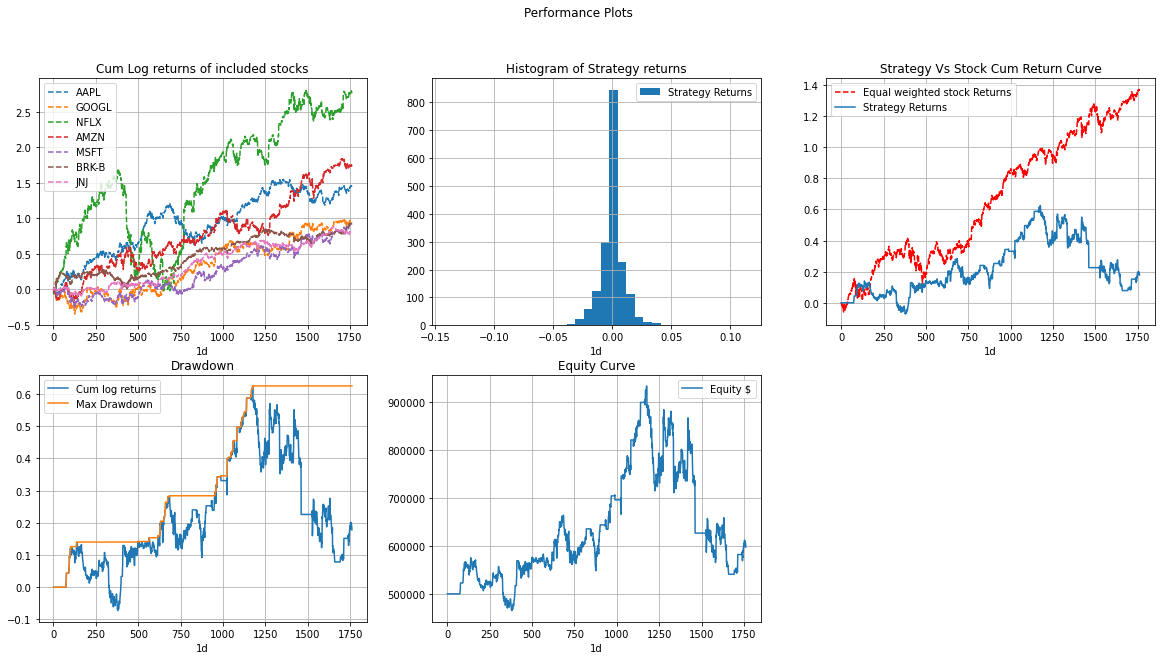

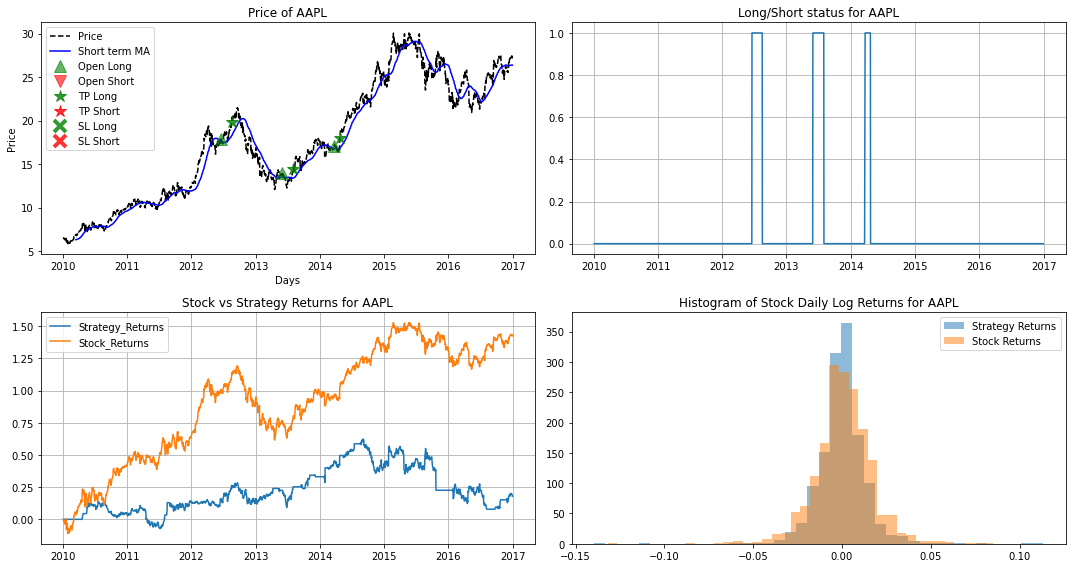

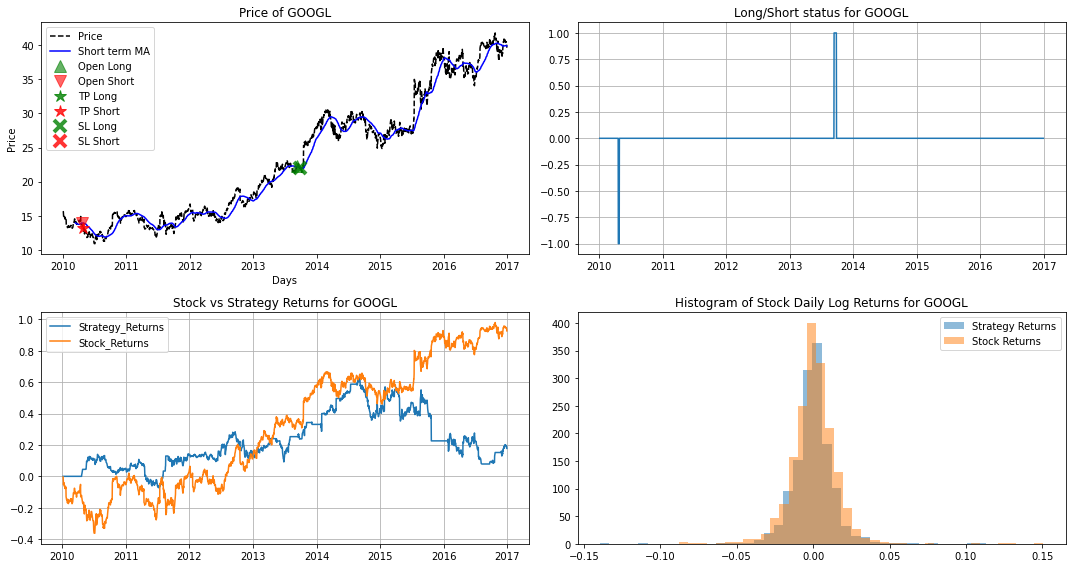

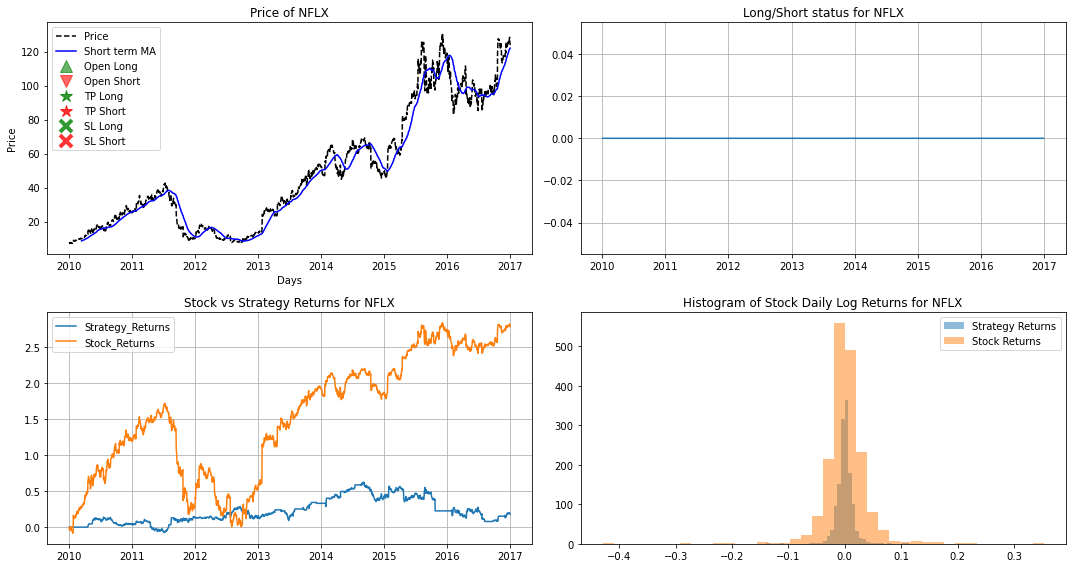

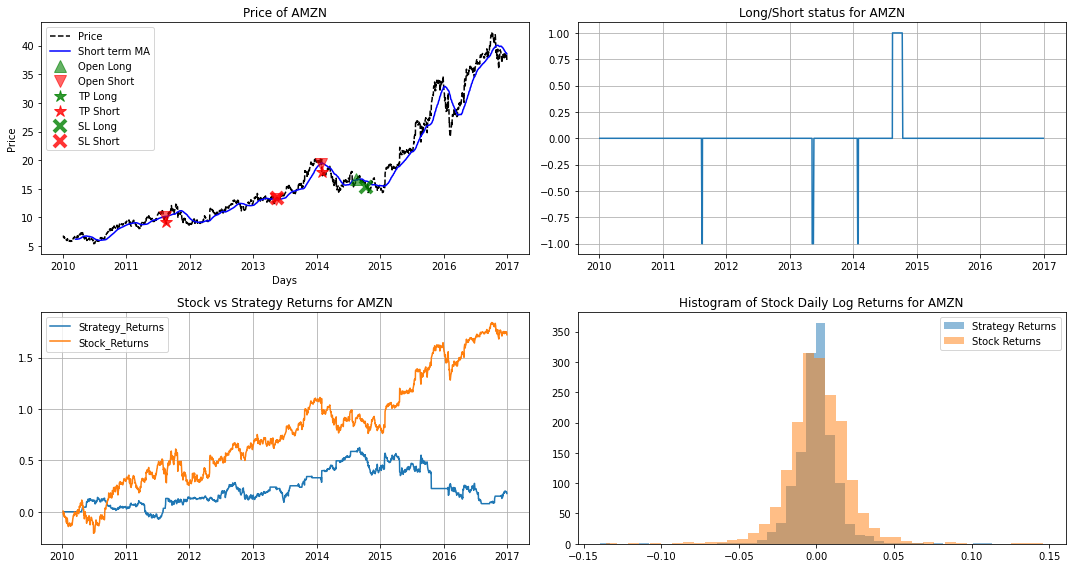

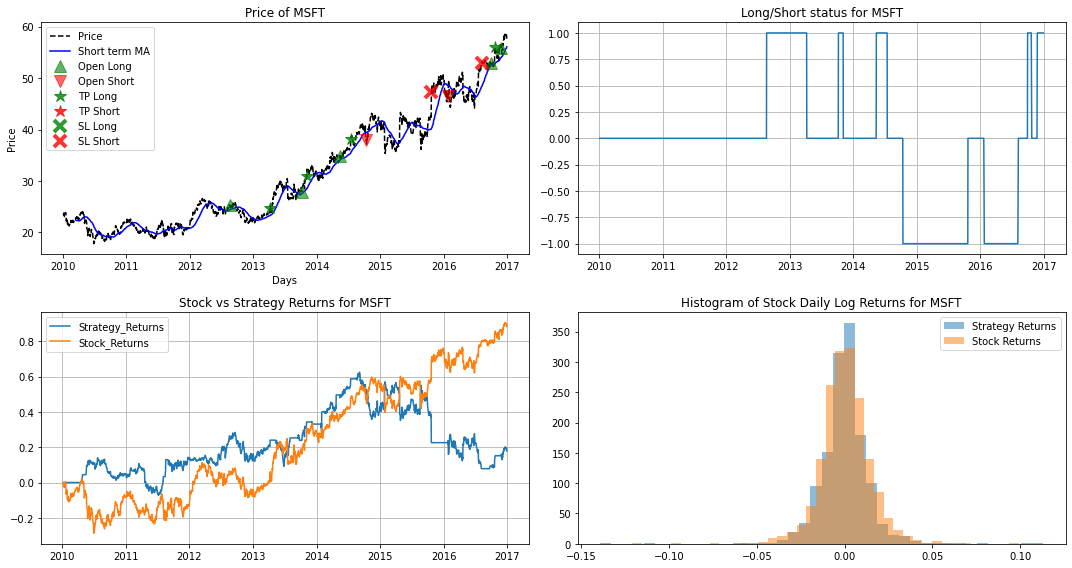

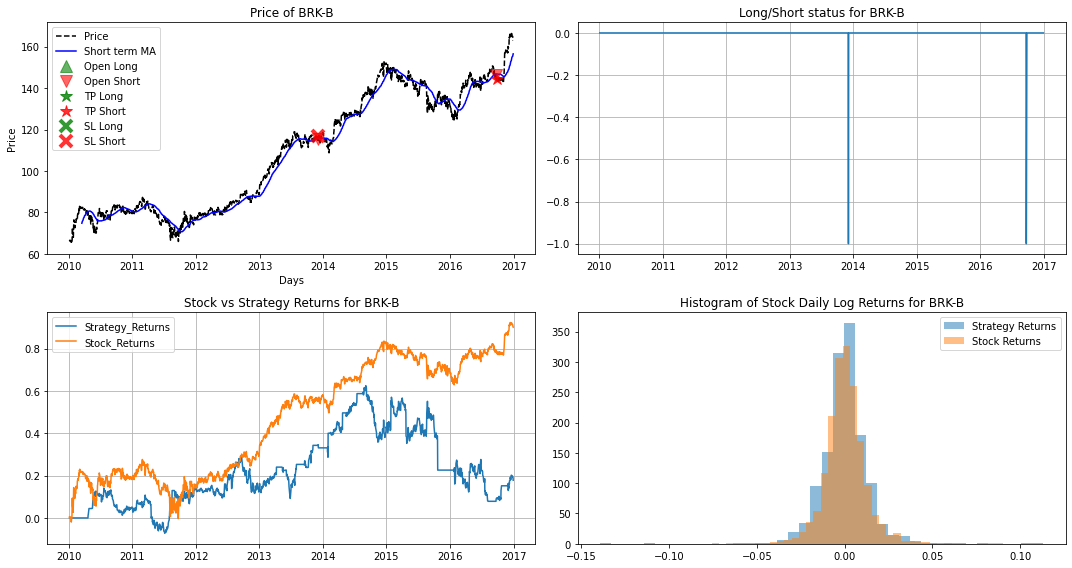

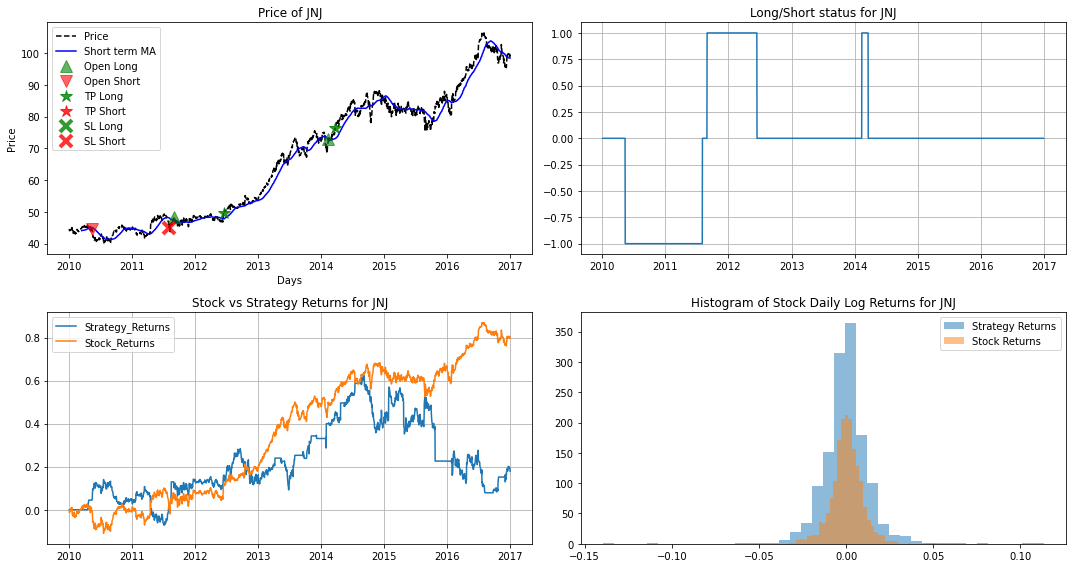

In [580]:
A.run_strategy()

In [491]:
A.all_data['AAPL'].to_clipboard()

In [359]:
A.strengths_df

,AAPL,GOOGL,NFLX,AMZN,Chosen
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2016-12-23,0.125014,0.080487,0.146238,0.0,NFLX
2016-12-27,0.121008,0.060220,0.269449,0.0,NFLX
2016-12-28,0.096240,0.017606,0.126473,0.0,NFLX


In [360]:
A.Final_result_data

,capital,Returns_AAPL,Returns_GOOGL,Returns_NFLX,Returns_AMZN,Total_Stock_Returns,Total_Stock_Returns_cum_sum,capital_after_settlement,capital_regular_returns,capital_log_returns,capital_returns_log_cum_sum,Cum_Max,drawdown,Benchmark Returns,portfolio-benchmark,portfolio_gross_cum_returns,portfolio_gross_cum_max_returns
0,500000.000000,0.015445,0.010861,-0.029660,-0.004620,-0.001994,-0.001994,500000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015916,-0.015916,1.000000,1.00000
1,500000.000000,0.001728,-0.004413,-0.037532,0.005883,-0.008584,-0.010577,500000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003111,-0.003111,1.000000,1.00000
2,500000.000000,-0.016034,-0.025532,0.034536,-0.018282,-0.006328,-0.016905,500000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000545,-0.000545,1.000000,1.00000
3,500000.000000,-0.001850,-0.023555,-0.017405,-0.017160,-0.014992,-0.031898,500000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003993,-0.003993,1.000000,1.00000
4,500000.000000,0.006626,0.013243,0.017030,0.026717,0.015904,-0.015994,500000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002878,-0.002878,1.000000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,571322.234526,0.001976,-0.002325,0.000080,-0.007532,-0.001950,1.726473,574950.680567,0.006351,0.006331,0.139676,1.005279,0.865603,0.001251,0.005080,1.149901,2.73267
1758,574950.680567,0.006331,0.002633,0.021738,0.014113,0.011204,1.737677,572499.019194,-0.004264,-0.004273,0.135403,1.005279,0.869876,0.002246,-0.006519,1.144998,2.73267
1759,572499.019194,-0.004273,-0.006640,-0.019352,0.000946,-0.007330,1.730347,572352.080999,-0.000257,-0.000257,0.135146,1.005279,0.870133,-0.008392,0.008135,1.144704,2.73267
1760,572352.080999,-0.000257,-0.002103,-0.004458,-0.009081,-0.003975,1.726373,567890.172421,-0.007796,-0.007826,0.127320,1.005279,0.877959,-0.000293,-0.007533,1.135780,2.73267


In [361]:
A.performance()

Starting capital: 500000
Final capital: 567890.17
Log Portfolio returns: 12.73 %
Normal Portfolio returns: 13.58 %
Portfolio Annual Mean returns: 0.02
Portfolio Annual Regular std: 0.26
Portfolio Annual Sharpe Ratio: 0.07
^GSPC Benchmark Annual Mean returns: 0.10
Annual Information Ratio: -0.27
Portfolio Treynor Ratio: 3.90
Portfolio Calmar Ratio: 0.01
Portfolio Sortino Ratio: 0.10
The maximum drawdown: 105.67 %
The maximum drawdown period: 103.00 days
The total trades taken by the strategy: 107


In [42]:
trade_start_date

'2015-03-17'

In [43]:
trade_end_date

'2019-12-31'

In [57]:
A.capital_per_day

,capital,Returns_AAPL,Returns_GOOGL,Returns_NFLX,Returns_AMZN,Returns_META,Total_Stock_Returns,Total_Stock_Returns_cum_sum,capital_after_settlement,capital_regular_returns,capital_log_returns,capital_returns_log_cum_sum,Cum_Max,drawdown
0,39600.014464,0.016588,-0.007201,-0.008210,-0.003837,0.016389,0.002746,0.002746,38756.004218,-0.021313,-0.021544,-0.021544,-0.021544,0.000000
1,38756.004218,0.011194,0.015217,0.010931,0.008620,0.019343,0.013061,0.015807,38368.455676,-0.010000,-0.010050,-0.031594,-0.021544,0.010050
2,38368.455676,-0.007579,-0.004408,0.004927,-0.005078,0.022487,0.002070,0.017877,38299.414878,-0.001799,-0.001801,-0.033395,-0.021544,0.011851
3,38299.414878,-0.012629,0.002268,0.007241,0.013968,0.012609,0.004691,0.022568,37917.199287,-0.009980,-0.010030,-0.043425,-0.021544,0.021881
4,37917.199287,0.010351,0.000743,-0.007735,-0.008970,0.007490,0.000376,0.022944,36172.378223,-0.046017,-0.047109,-0.090534,-0.021544,0.068990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,44310.573125,-0.021877,-0.005284,-0.010864,-0.006158,-0.007753,-0.010387,1.105865,47170.812561,0.064550,0.062552,0.174946,0.399547,0.224601
1161,47170.812561,0.001643,0.001176,0.000848,0.010506,0.001235,0.003081,1.097995,53792.420620,0.140375,0.131357,0.306303,0.399547,0.093244
1203,53792.420620,0.000950,-0.004601,0.000300,-0.002116,-0.005154,-0.002124,1.203665,57352.861122,0.066189,0.064090,0.370393,0.399547,0.029154
1206,57352.861122,0.005918,-0.011083,-0.017720,-0.012328,-0.017891,-0.010621,1.207625,59049.544138,0.029583,0.029154,0.399547,0.399547,0.000000
